In [1]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm_notebook, tqdm
tqdm_notebook().pandas()
import pickle
# from pandarallel import pandarallel # for linux and mac
# pandarallel.initialize()

In [2]:
results = pd.read_csv('results.csv')
results.loc[:, 'mask'] = results.loc[:, 'mask'].str.replace('X', '')
roster = pd.read_csv('roster.csv')#.set_index('idplayer')
tournaments = pd.read_csv('tournaments.csv').set_index('idtournament')
tournaments = tournaments.loc[~tournaments.questions_total.isnull(), :]
common_tours = list(set(tournaments.index).intersection(set(results.idtournament)))
results = results.loc[results.idtournament.isin(common_tours), :]
tournaments = tournaments.loc[common_tours, :]

q_total = pd.DataFrame(results.groupby('idtournament').first()\
                       .loc[:, 'mask'].str.len()).dropna().rename(columns={'mask': 'questions_total'})
tournaments = pd.merge(tournaments.drop(columns=['questions_total']), q_total, left_index=True, right_index=True)

In [3]:
ineligible_tournaments = [1521, 1526, 1531, 1534, 1780, 1817, 1849, 1854, 1858, 1885, 1893, 1902, 1925, 1926, 1928,
                          1931, 1960, 2025, 2040, 2077, 2087, 2128, 2147, 2151, 2166, 2183, 2291, 2345, 2346, 2472,
                          2479, 2512, 2521, 2578, 2611, 2707, 2732, 2763, 2783, 2833, 3130, 3162, 3231, 3510, 3589,
                          3590, 3617, 4011, 4169, 4375, 4469, 4481, 4497, 4713, 4714, 4816, 4860, 4881, 4913, 4946,
                          4969, 4983, 4984, 4989, 4990, 4992, 5032, 5054, 5097, 5102, 5106, 5121, 5126, 5160, 5178,
                          5210, 5215, 5221, 5239, 5241, 5247, 5299, 5310,
                          # nan tours
                          1954, 1989, 1970, 1810, 1917, 2373, 2219, 1969,  314, 1824, 2102, 2241, 2249, 2014, 2220,
                          2363, 2703, 2234, 2417, 2171, 2126, 1900, 2013, 2394, 1792, 1689, 1590, 1987, 1895, 1991,
                          2119, 1951, 1899,1898, 2224, 1976, 2100
                         ]
results = results.loc[~results.idtournament.isin(ineligible_tournaments), :]
results.loc[:, 'mask'] = results.loc[:, 'mask'].apply(lambda x: list(str(x)))
roster = roster.loc[~roster.idtournament.isin(ineligible_tournaments), :]

In [4]:
READ=True
if READ:
    with open('results.pickle', 'rb') as f:
        results = pickle.load(f)
else:
    with open('results.pickle', 'wb') as f:
        pickle.dump(results, f)

In [5]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    orders = [num for range_len in lens for num in range(range_len)]
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    
    res.loc[:, 'q_numb'] = orders
    return res

In [6]:
exp = explode(results.loc[:, ['idteam', 'idtournament', 'mask', 'players']], ['mask'], fill_value='', preserve_index=False)\
            .rename(columns={'mask': 'q_taken'})
exp.head(1)

,idteam,idtournament,players,q_taken,q_numb
0,209,3236,"[5974, 7474, 13601, 15624, 19298, 32017]",1,0


In [7]:
%%timeit -n1 -r1
# exp.loc[:, 'q_id_old'] = exp.idtournament.map(str) + "_" + exp.idteam.map(str) + "_" + exp.q_numb.map(str)
# exp.loc[:, 'q_id'] = (exp.idtournament.map(str) + "0000" + exp.idteam.map(str) + "0000" + exp.q_numb.map(str)).map(int)
exp.loc[:, 'q_id'] = exp.idtournament * 1000000000 + exp.idteam * 1000 + exp.q_numb
exp['q_taken'] = exp.q_taken.astype(int)
# len(exp.q_id.unique()) == len(exp.q_id_old.unique()) check for losses

1.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [8]:
exp.head(1)

,idteam,idtournament,players,q_taken,q_numb,q_id
0,209,3236,"[5974, 7474, 13601, 15624, 19298, 32017]",1,0,3236000209000


## Players skills and question difficulties as numpy arrays
https://stackoverflow.com/questions/36652533/looking-up-large-sets-of-keys-dictionary-vs-numpy-array

In [9]:
LOAD = True
if LOAD:
    with open('skills.pickle', 'rb') as f:
        skills = pickle.load(f)
    with open('difficulties.pickle', 'rb') as f:
        difficulties = pickle.load(f)
else:
    skill_ids = roster.sort_values('idplayer').idplayer.unique()
    skills = np.array(list(zip(skill_ids, np.random.uniform(0,1, len(skill_ids))))   )

    dif_ids = np.sort(exp.q_id.unique())
    difficulties = np.array(list(zip(dif_ids, np.random.uniform(0,1, len(dif_ids))))   )

In [10]:
def team_performance(players):
#     row_idx = np.searchsorted(skills[:,0], key_set)[key_set.argsort()]
#     row_idx = np.searchsorted(skills[:,0], players)
#     values = skills[row_idx, 1]
    return np.mean(
        skills[np.searchsorted(skills[:,0], players), 1] 
    )
def get_difficulties_by_q_id(q_ids):
    return difficulties[np.searchsorted(difficulties[:,0], q_ids), 1]#[q_ids.argsort()]
def sigmoid(x):
    return 1 / (1 + pd.np.exp(-x))

## Learning

**Model**<br>
$p(y=1| S_{team}, \theta) = \sigma(S_{team} - \theta)$ <br>
$S_{team}$ - team skill<br>
$S_{team} = S_{player\_1} + S_{player\_2} + ... + S_{player\_N}$<br>
$\theta_j$ - difficulty of question j<br>
y - team answer, 1 for correct, 2 for incorrect<br>
$p(y_{hat}=y_{real}| S_{team}, \theta) = \sigma(S_{team} - \theta)^{y_{real}} * (1-\sigma(S_{team} - \theta))^{(1-y_{real})}$<br>
<br>
$LikelyHood = \frac{1}{N}\prod_{i=1}^{N} p(y_{hat\_i}=y_{real\_i}| S_{team}, \theta)$<br>
$log(LikelyHood) = LL = \frac{1}{N}\sum_{i=1}^{N} log(p(y_{hat\_i}=y_{real\_i}| S_{team}, \theta))=
y_{real}*log(\sigma(S_{team} - \theta)) + (1-y_{real})* log(1-\sigma(S_{team} - \theta))$<br>
<br>
$-log(LikelyHood) \rightarrow min$ w.r.t. $S_{player\_i}$ and $\theta_j$

**Derivatives:**

$\sigma'(x) = \sigma(x)*(1-\sigma(x))$

$\frac{\partial LL}{\partial \theta} = \frac{y_{real}}{\sigma(S_{team} - \theta)} * \sigma'(S_{team} - \theta) * (-1) +
\frac{1-y_{real}}{1-\sigma(S_{team} - \theta)} * (-\sigma'(S_{team} - \theta)) * (-1) = 
-y_{real}*(1-\sigma(S_{team} - \theta)) + (1-y_{real})*\sigma(S_{team} - \theta)
$<br>

$\frac{\partial LL}{\partial S_i} = \frac{y_{real}}{\sigma(S_{team} - \theta)} * \sigma'(S_{team} - \theta) +
\frac{1-y_{real}}{1-\sigma(S_{team} - \theta)} * (-\sigma'(S_{team} - \theta)) = 
y_{real}*(1-\sigma(S_{team} - \theta)) - (1-y_{real})*\sigma(S_{team} - \theta)$<br>


**Short derivatives:**

$\frac{\partial -LL}{\partial \theta} = +y_{real}*(1-\sigma(S_{team} - \theta)) - (1-y_{real})*\sigma(S_{team} - \theta)
$<br>

$\frac{\partial -LL}{\partial S_i} = -y_{real}*(1-\sigma(S_{team} - \theta)) + (1-y_{real})*\sigma(S_{team} - \theta)$<br>


**Gradient update**<br>
$S_{i\_new} = S_{i\_old} - learning\_rate * \frac{\partial LL}{\partial S_i}$<br>
$\theta_{new} = \theta_{old} - learning\_rate * \frac{\partial LL}{\partial \theta}$<br>

In [11]:
def sgd(lr=0.01, epochs=10, batch_size=16):
    for _ in tqdm_notebook(range(epochs)):
        # get batch
        batch = exp.sample(n=batch_size)
        # calculate team performance
        t_perf = batch['players'].apply(lambda members: team_performance(members))
        # get question difficulty
        q_dif = batch['q_id'].apply(lambda question: get_difficulties_by_q_id(question))
        # calculate  result 
        team_sigmoid = sigmoid(t_perf - q_dif)
        # update question difficulty
        q_dif_update = lr * (batch['q_taken'] * (1-team_sigmoid) - (1-batch['q_taken'])*team_sigmoid)
        difficulties[np.searchsorted(difficulties[:,0], batch['q_id']), 1] -= q_dif_update
        # update player skills
        skill_update = -(lr * (batch['q_taken'] * (1-team_sigmoid) - (1-batch['q_taken'])*team_sigmoid) /
                     batch['players'].str.len())
        for idx in range(batch_size):
            skills[np.searchsorted(skills[:,0], batch['players'].iloc[idx]), 1] -= skill_update.iloc[idx]

In [57]:
# sgd(lr=0.1, epochs=20000, batch_size=5000) 
# sgd(lr=0.1, epochs=20000, batch_size=5000)
# sgd(lr=0.1, epochs=20000, batch_size=5000)
# sgd(lr=0.05, epochs=20000, batch_size=5000)
sgd(lr=0.05, epochs=2000, batch_size=5000)
# epochs 20k, batch 5k ETA 4:20 hours

# sgd(lr=0.05, epochs=50, batch_size=1000)

In [58]:
DUMP=True
if DUMP:
    with open('skills.pickle', 'wb') as f:
        pickle.dump(skills, f)
    with open('difficulties.pickle', 'wb') as f:
        pickle.dump(difficulties, f)

In [59]:
def calculate_loss(copy=True):
    if copy:
        df = exp.copy(deep=True)
        df = df.iloc[0:500]
        #     df.loc[:, 't_sigm'] = df.progress_apply(lambda row: sigmoid(team_performance(row['players']) - get_difficulties_by_q_id(row['q_id']) ), axis=1)
        df.loc[:, 't_sigm'] = df.apply(lambda row: sigmoid(team_performance(row['players']) - get_difficulties_by_q_id(row['q_id']) ), axis=1)
        df.loc[:, 'one_loss'] = df['q_taken']*np.log(df['t_sigm']) + (1-df['q_taken'])*np.log(1-df['t_sigm'])
        total_loss = -df['one_loss'].sum()
        print(total_loss)
    else:
#         exp.loc[:, 't_sigm'] = exp.apply(lambda row: sigmoid(team_performance(row['players']) - get_difficulties_by_q_id(row['q_id']) ), axis=1)
        exp.loc[:, 't_sigm'] = exp.progress_apply(lambda row: sigmoid(team_performance(row['players']) - get_difficulties_by_q_id(row['q_id']) ), axis=1)
        exp.loc[:, 'one_loss'] = exp['q_taken']*np.log(exp['t_sigm']) + (1-exp['q_taken'])*np.log(1-exp['t_sigm'])
        total_loss = -exp['one_loss'].sum()
        print(total_loss)

In [60]:
calculate_loss(copy=False)


322747.066216849


## ROC AUC

In [62]:
exp.head(2)

,idteam,idtournament,players,q_taken,q_numb,q_id,t_sigm,one_loss
0,209,3236,"[5974, 7474, 13601, 15624, 19298, 32017]",1,0,3236000209000,0.95157,-0.049642
1,209,3236,"[5974, 7474, 13601, 15624, 19298, 32017]",1,1,3236000209001,0.95034,-0.050935


In [70]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [64]:
roc_auc_score(exp.q_taken, exp.t_sigm)

1.0

In [ ]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(exp.q_taken, exp.t_sigm)
roc_auc = auc(fpr, tpr)

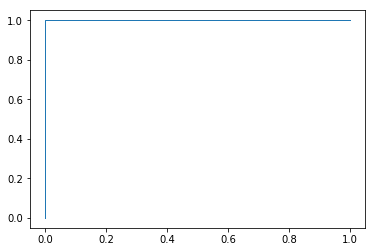

In [72]:
plt.plot(fpr, tpr, lw=1, alpha=1)

In [73]:
sum(abs(exp.q_taken-exp.t_sigm) > 0.1)

3

## Exploit

In [61]:
def at_least_same_taken_prob(probabilities, taken):
    ques_amount = len(probabilities)
    prob_matrix = np.zeros(shape=(ques_amount+1, ques_amount+1))
    prob_matrix[0, 0] = 1
    for i in range(ques_amount+1):
        for j in range(1, ques_amount+1):
            prob_matrix[i, j] = prob_matrix[i, j-1] * (1 - probabilities[j-1]) +\
                                prob_matrix[i-1, j-1] * probabilities[j-1]
    return prob_matrix[taken:, -1].sum()

In [54]:
result = exp.groupby(['idtournament', 'idteam'])\
            .progress_apply(lambda row: at_least_same_taken_prob(row['t_sigm'].tolist(), row['q_taken'].sum()))\
            .reset_index()\
            .rename(columns={0: 'prob'})\
            .sort_values('prob')\
            .reset_index(drop=True)

In [55]:
result.head()

,idtournament,idteam,prob
0,141,1,0.038739
1,484,967,0.082722
2,315,2283,0.083421
3,315,1008,0.092291
4,1224,28674,0.092318


In [79]:
susp_team = results.loc[(results.idteam == 1) & (results.idtournament == 141), 'players'].item()

In [ ]:
filter()